**iş problemi:**

Maaş bilgileri ve 1986 yılına ait kariyer istatistikleri paylaşılan beyzbol
oyuncularının maaş tahminleri için bir makine öğrenmesi modeli geliştiriniz.

**Veri Seti Hikayesi:**

Bu veri seti orijinal olarak Carnegie Mellon Üniversitesi'nde bulunan
StatLib kütüphanesinden alınmıştır. Veri seti 1988 ASA Grafik Bölümü
Poster Oturumu'nda kullanılan verilerin bir parçasıdır. Maaş verileri
orijinal olarak Sports Illustrated, 20 Nisan 1987'den alınmıştır. 1986 ve
kariyer istatistikleri, Collier Books, Macmillan Publishing Company,
New York tarafından yayınlanan 1987 Beyzbol Ansiklopedisi
Güncellemesinden elde edilmiştir.

**Değişkenler:**

**AtBat:** 1986-1987 sezonunda bir beyzbol sopası ile topa yapılan vuruş sayısı

**Hits:** 1986-1987 sezonundaki isabet sayısı

**HmRun:** 1986-1987 sezonundaki en değerli vuruş sayısı

**Runs:** 1986-1987 sezonunda takımına kazandırdığı sayı

**RBI:** Bir vurucunun vuruş yaptıgında koşu yaptırdığı oyuncu sayısı

**Walks:** Karşı oyuncuya yaptırılan hata sayısı
Years Oyuncunun major liginde oynama süresi (sene)

**CAtBat:** Oyuncunun kariyeri boyunca topa vurma sayısı

**CHits:** Oyuncunun kariyeri boyunca yaptığı isabetli vuruş sayısı

**CHmRun:** Oyucunun kariyeri boyunca yaptığı en değerli sayısı

**CRuns:** Oyuncunun kariyeri boyunca takımına kazandırdığı sayı

**CRBI:** Oyuncunun kariyeri boyunca koşu yaptırdırdığı oyuncu sayısı

**CWalks:** Oyuncun kariyeri boyunca karşı oyuncuya yaptırdığı hata sayısı

**League:** Oyuncunun sezon sonuna kadar oynadığı ligi gösteren A ve N seviyelerine sahip bir faktör

**Division:** 1986 sonunda oyuncunun oynadığı pozisyonu gösteren E ve W seviyelerine sahip bir faktör

**PutOuts:** Oyun icinde takım arkadaşınla yardımlaşma

**Assits:** 1986-1987 sezonunda oyuncunun yaptığı asist sayısı

**Errors:** 1986-1987 sezonundaki oyuncunun hata sayısı

**Salary:** Oyuncunun 1986-1987 sezonunda aldığı maaş(bin uzerinden)

**NewLeague:** 1987 sezonunun başında oyuncunun ligini gösteren A ve N seviyelerine sahip bir faktör

Gerekli Kütüphaneler ve Fonksiyonlar

In [5]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve

#from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [9]:
#from pandas.core.common import SettingWithCopyWarning
#from sklearn.exceptions import ConvergenceWarning

In [10]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action="ignore", category=ConvergenceWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# 1. Genel Resim

In [11]:
df = pd.read_csv("/content/sample_data/hitters.csv")

In [12]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    print(dataframe.head(head))

    print("##################### Tail #####################")
    print(dataframe.tail(head))

    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [13]:
check_df(df)

##################### Shape #####################
(322, 20)
##################### Types #####################
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
##################### Head #####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        

In [14]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [15]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


# 2. Kategorik Değişken Analizi (Analysis of Categorical Variables)

   League  Ratio
A     175 54.348
N     147 45.652
##########################################


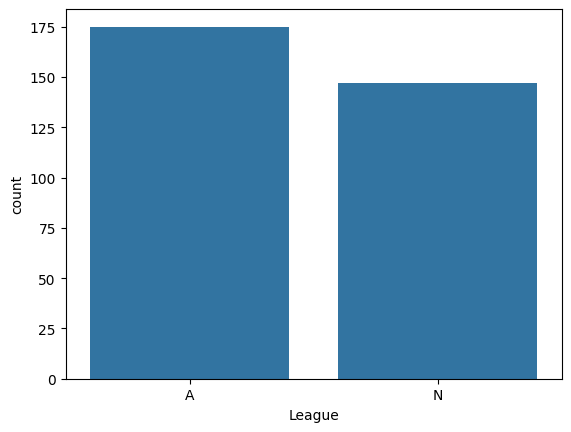

   Division  Ratio
W       165 51.242
E       157 48.758
##########################################


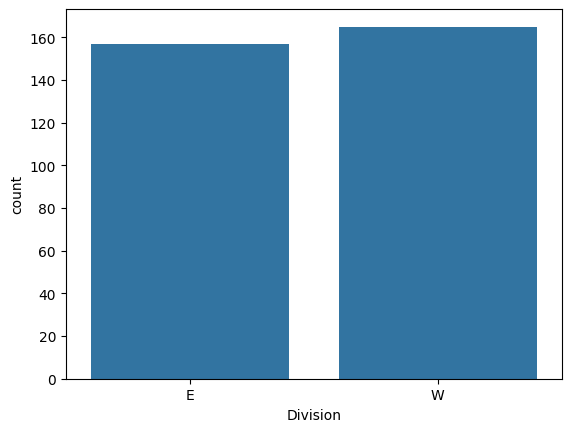

   NewLeague  Ratio
A        176 54.658
N        146 45.342
##########################################


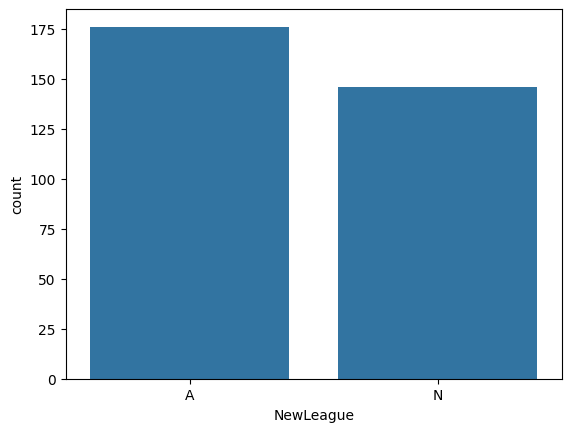

In [16]:
def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col, plot=True)

## 3. Sayısal Değişken Analizi (Analysis of Numerical Variables)

count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64


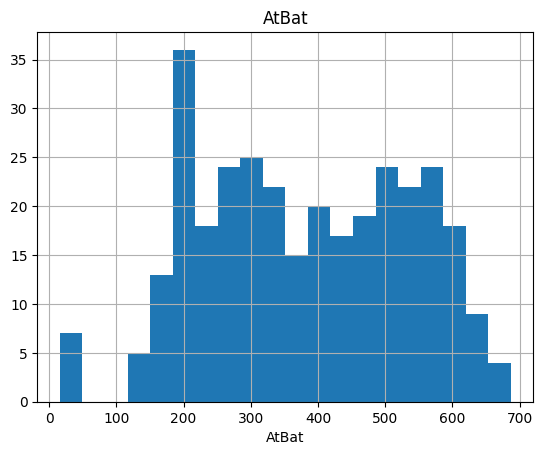

count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64


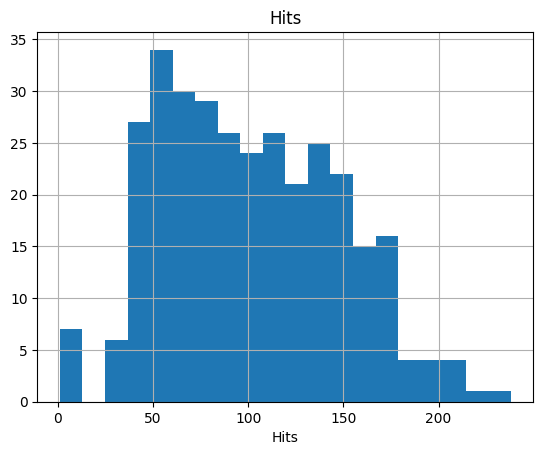

count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       5.000
40%       6.000
50%       8.000
60%      10.600
70%      14.000
80%      18.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64


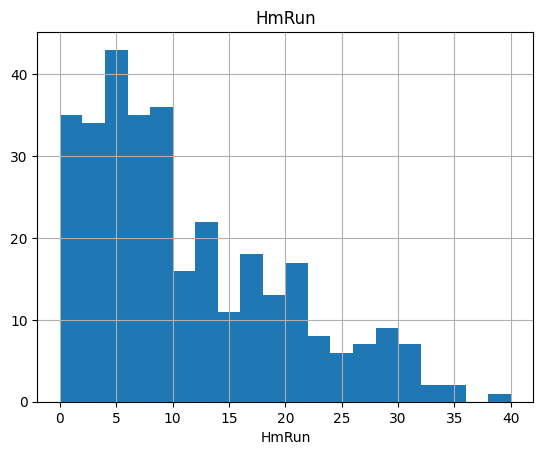

count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
20%      27.000
30%      33.000
40%      41.000
50%      48.000
60%      55.600
70%      66.000
80%      75.800
90%      89.000
95%      94.000
99%     107.790
max     130.000
Name: Runs, dtype: float64


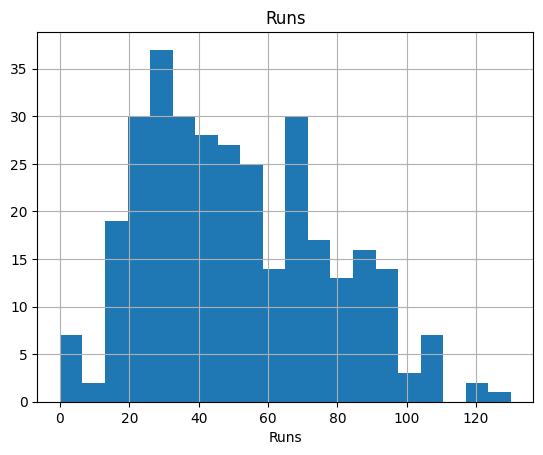

count   322.000
mean     48.028
std      26.167
min       0.000
5%       14.000
10%      19.000
20%      26.000
30%      30.000
40%      36.400
50%      44.000
60%      49.000
70%      58.000
80%      73.000
90%      86.000
95%      96.000
99%     112.370
max     121.000
Name: RBI, dtype: float64


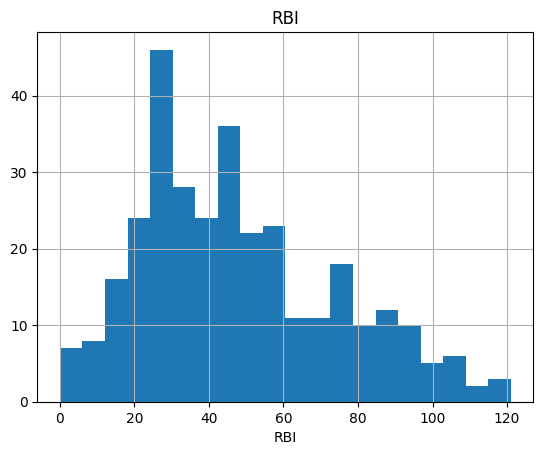

count   322.000
mean     38.742
std      21.639
min       0.000
5%       11.050
10%      15.000
20%      20.000
30%      24.000
40%      30.000
50%      35.000
60%      40.000
70%      48.700
80%      59.000
90%      69.900
95%      78.000
99%      93.580
max     105.000
Name: Walks, dtype: float64


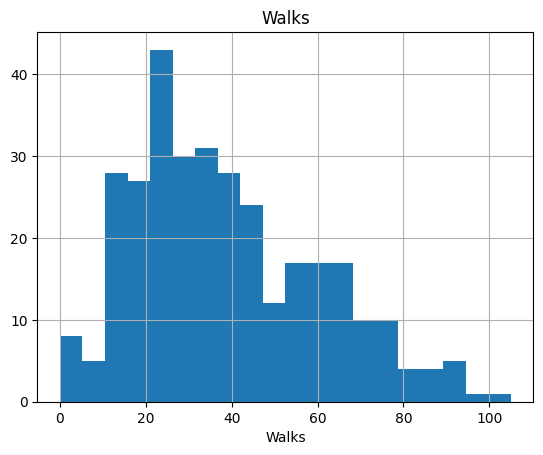

count   322.000
mean      7.444
std       4.926
min       1.000
5%        1.000
10%       2.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       7.600
70%      10.000
80%      12.000
90%      15.000
95%      17.000
99%      19.790
max      24.000
Name: Years, dtype: float64


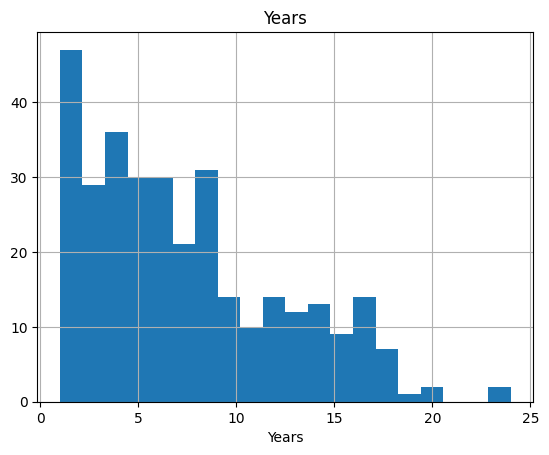

count     322.000
mean     2648.683
std      2324.206
min        19.000
5%        216.500
10%       342.200
20%       667.600
30%       963.400
40%      1402.200
50%      1928.000
60%      2654.000
70%      3365.000
80%      4483.000
90%      6123.400
95%      7125.600
99%      8749.970
max     14053.000
Name: CAtBat, dtype: float64


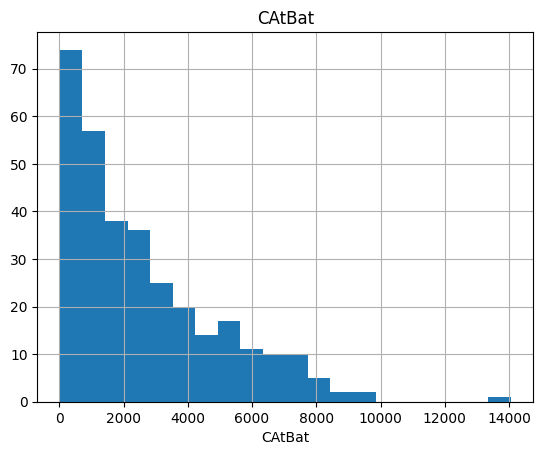

count    322.000
mean     717.571
std      654.473
min        4.000
5%        54.000
10%       86.000
20%      164.600
30%      238.000
40%      355.800
50%      508.000
60%      708.200
70%      911.100
80%     1229.200
90%     1659.600
95%     2017.150
99%     2500.340
max     4256.000
Name: CHits, dtype: float64


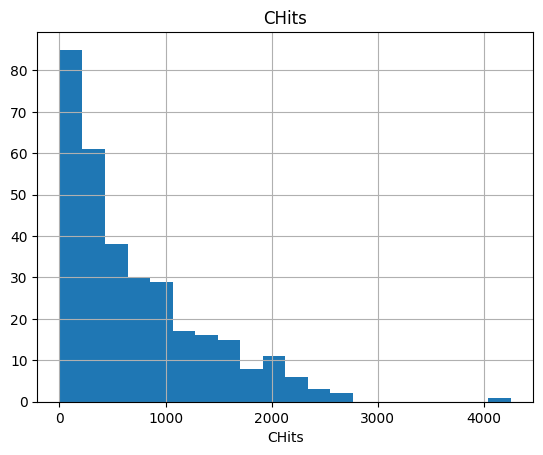

count   322.000
mean     69.491
std      86.266
min       0.000
5%        2.000
10%       4.000
20%      10.200
30%      16.300
40%      27.400
50%      37.500
60%      51.200
70%      72.400
80%     103.800
90%     194.900
95%     265.650
99%     373.120
max     548.000
Name: CHmRun, dtype: float64


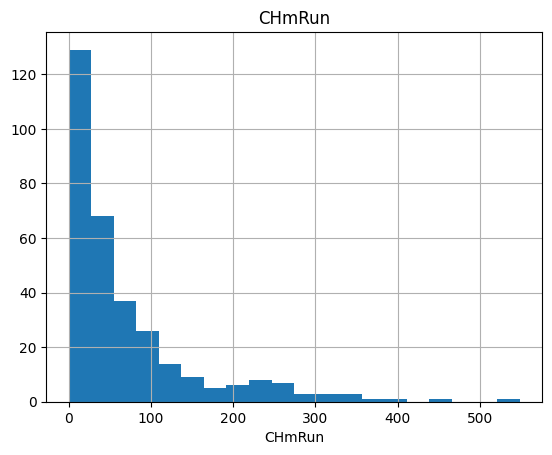

count    322.000
mean     358.795
std      334.106
min        1.000
5%        27.000
10%       38.100
20%       80.400
30%      117.300
40%      181.000
50%      247.000
60%      333.000
70%      443.400
80%      627.200
90%      895.700
95%     1032.300
99%     1174.370
max     2165.000
Name: CRuns, dtype: float64


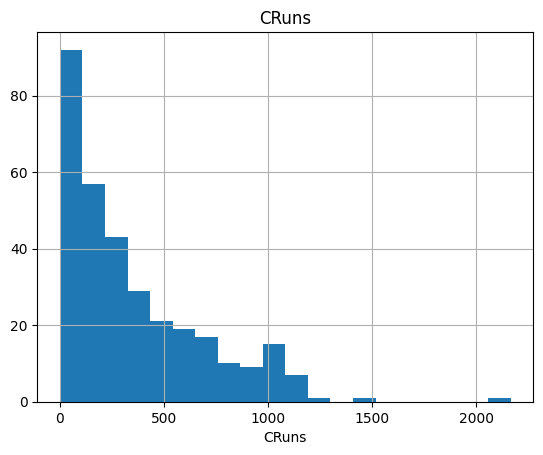

count    322.000
mean     330.118
std      333.220
min        0.000
5%        22.050
10%       34.100
20%       70.200
30%      106.300
40%      149.000
50%      220.500
60%      303.600
70%      379.100
80%      496.200
90%      861.600
95%     1071.750
99%     1310.850
max     1659.000
Name: CRBI, dtype: float64


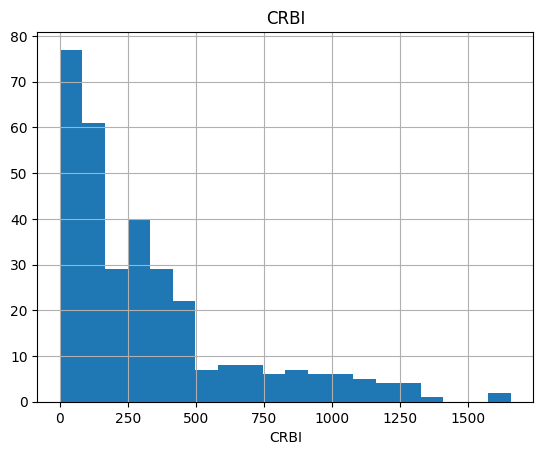

count    322.000
mean     260.239
std      267.058
min        0.000
5%        15.050
10%       30.100
20%       55.000
30%       82.000
40%      117.400
50%      170.500
60%      226.600
70%      300.700
80%      421.000
90%      643.900
95%      817.600
99%     1139.140
max     1566.000
Name: CWalks, dtype: float64


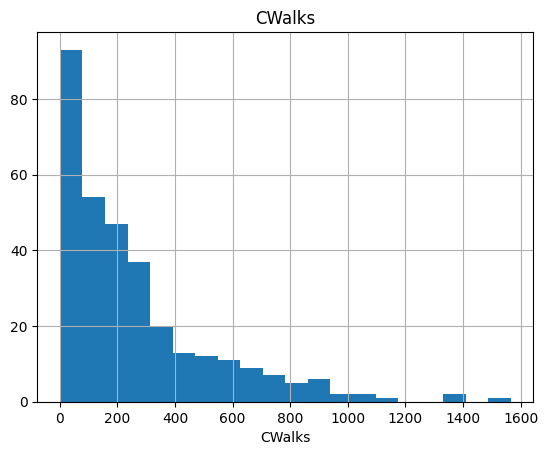

count    322.000
mean     288.938
std      280.705
min        0.000
5%        33.200
10%       62.200
20%       99.600
30%      132.000
40%      167.000
50%      212.000
60%      257.400
70%      303.000
80%      365.800
90%      685.600
95%      910.650
99%     1301.190
max     1378.000
Name: PutOuts, dtype: float64


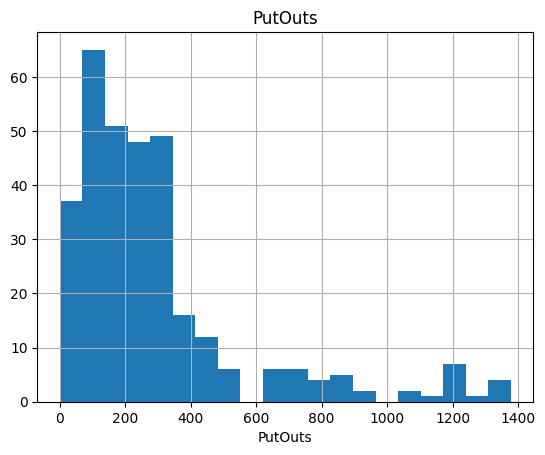

count   322.000
mean    106.913
std     136.855
min       0.000
5%        0.000
10%       2.000
20%       5.200
30%       9.000
40%      15.400
50%      39.500
60%      76.800
70%     134.800
80%     210.800
90%     353.300
95%     431.450
99%     478.160
max     492.000
Name: Assists, dtype: float64


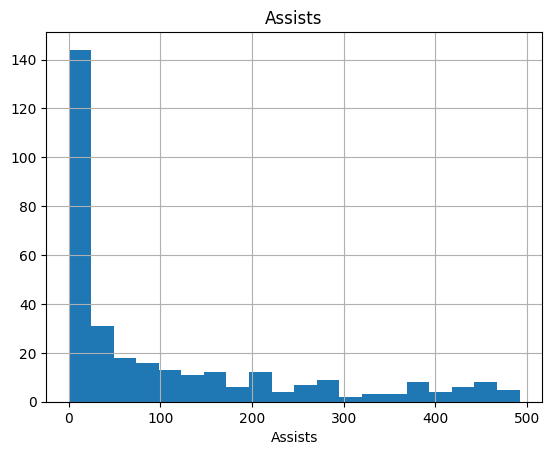

count   322.000
mean      8.040
std       6.368
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       8.000
70%      10.000
80%      13.000
90%      17.000
95%      20.000
99%      25.790
max      32.000
Name: Errors, dtype: float64


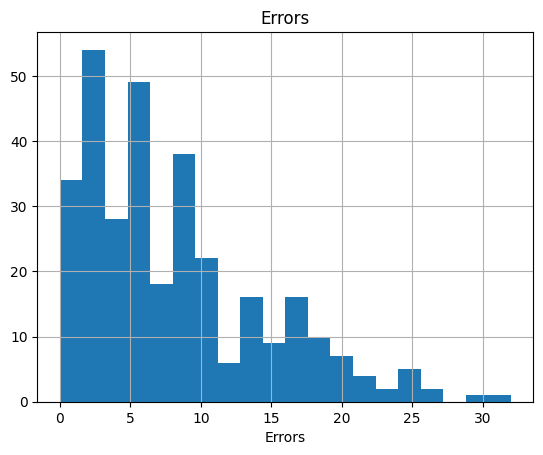

count    263.000
mean     535.926
std      451.119
min       67.500
5%        86.600
10%      100.000
20%      155.000
30%      221.000
40%      300.000
50%      425.000
60%      538.000
70%      700.000
80%      809.000
90%     1048.667
95%     1346.000
99%     2032.887
max     2460.000
Name: Salary, dtype: float64


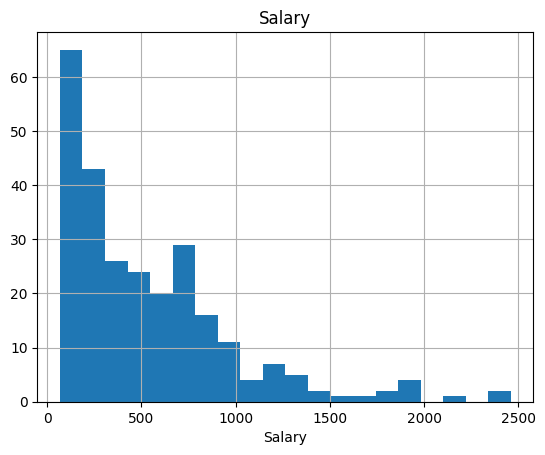

In [17]:
def num_summary(dataframe, numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

## 4. Hedef Değişken Analizi (Analysis of Target Variable)


In [18]:
def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Salary", col)

        TARGET_MEAN
League             
A           542.000
N           529.118


          TARGET_MEAN
Division             
E             624.271
W             450.877


           TARGET_MEAN
NewLeague             
A              537.113
N              534.554




## 5. Korelasyon Analizi (Analysis of Correlation)

In [21]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))  # Use bool directly
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

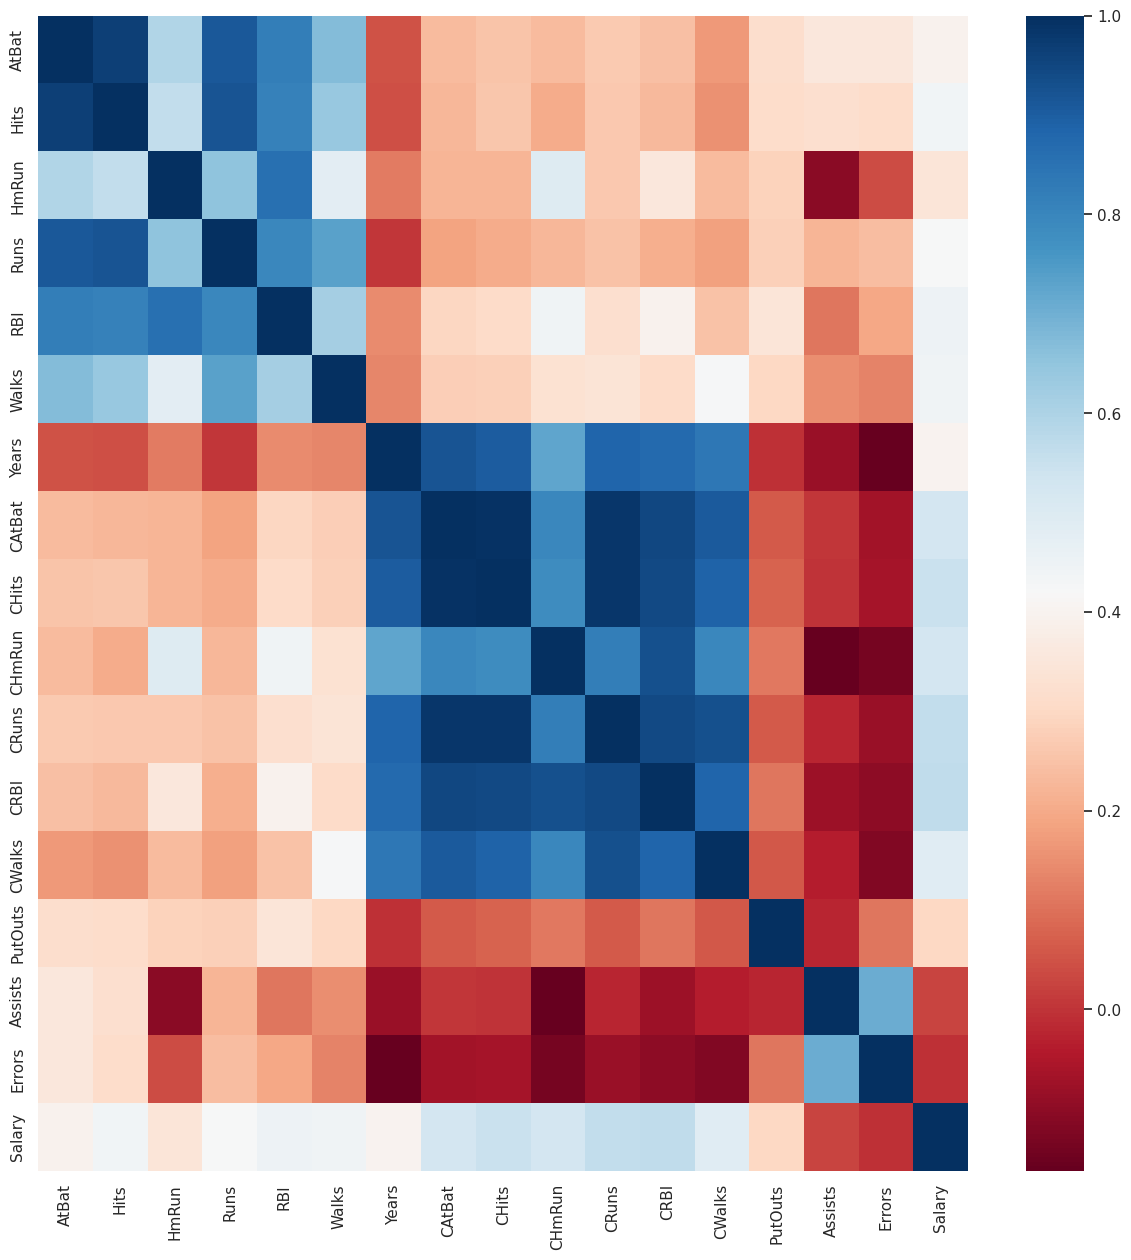

['Hits',
 'Runs',
 'RBI',
 'Walks',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'Errors']

In [22]:
high_correlated_cols(df, plot=True)

## GELİŞMİŞ FONKSİYONEL KEŞİFÇİ VERİ ANALİZİ (ADVANCED FUNCTIONAL EDA)

### 1. Outliers (Aykırı Değerler)

In [23]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [24]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [25]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [26]:
for col in num_cols:
    print(col, check_outlier(df, col))

AtBat False
Hits False
HmRun True
Runs True
RBI True
Walks True
Years True
CAtBat True
CHits True
CHmRun True
CRuns True
CRBI True
CWalks True
PutOuts True
Assists True
Errors True
Salary True


In [27]:
for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

### 2. Missing Values (Eksik Değerler)

In [28]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [29]:
missing_values_table(df)

        n_miss  ratio
Salary      59 18.320


In [30]:
df.dropna(inplace=True)

### 3. Feature Extraction (Özellik Çıkarımı)

In [31]:
new_num_cols=[col for col in num_cols if col!="Salary"]

In [32]:
df[new_num_cols]=df[new_num_cols]+0.0000000001

In [33]:
df['NEW_Hits'] = df['Hits'] / df['CHits'] + df['Hits']
df['NEW_RBI'] = df['RBI'] / df['CRBI']
df['NEW_Walks'] = df['Walks'] / df['CWalks']
df['NEW_PutOuts'] = df['PutOuts'] * df['Years']
df["Hits_Success"] = (df["Hits"] / df["AtBat"]) * 100
df["NEW_CRBI*CATBAT"] = df['CRBI'] * df['CAtBat']
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_Chits"] = df["CHits"] / df["Years"]
df["NEW_CHmRun"] = df["CHmRun"] * df["Years"]
df["NEW_CRuns"] = df["CRuns"] / df["Years"]
df["NEW_Chits"] = df["CHits"] * df["Years"]
df["NEW_RW"] = df["RBI"] * df["Walks"]
df["NEW_RBWALK"] = df["RBI"] / df["Walks"]
df["NEW_CH_CB"] = df["CHits"] / df["CAtBat"]
df["NEW_CHm_CAT"] = df["CHmRun"] / df["CAtBat"]
df['NEW_Diff_Atbat'] = df['AtBat'] - (df['CAtBat'] / df['Years'])
df['NEW_Diff_Hits'] = df['Hits'] - (df['CHits'] / df['Years'])
df['NEW_Diff_HmRun'] = df['HmRun'] - (df['CHmRun'] / df['Years'])
df['NEW_Diff_Runs'] = df['Runs'] - (df['CRuns'] / df['Years'])
df['NEW_Diff_RBI'] = df['RBI'] - (df['CRBI'] / df['Years'])
df['NEW_Diff_Walks'] = df['Walks'] - (df['CWalks'] / df['Years'])

In [34]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks
1,315.000,81.000,7.000,24.000,38.000,39.000,14.000,3449.000,835.000,69.000,321.000,414.000,375.000,N,W,632.000,43.000,10.000,475.000,N,81.097,0.092,0.104,8848.000,25.714,1427886.000,11690.000,966.000,22.929,1482.000,0.974,0.242,0.020,68.643,21.357,2.071,1.071,8.429,12.214
2,479.000,130.000,18.000,66.000,72.000,76.000,3.000,1624.000,457.000,63.000,224.000,266.000,263.000,A,W,648.625,82.000,14.000,480.000,A,130.284,0.271,0.289,1945.875,27.140,431984.000,1371.000,189.000,74.667,5472.000,0.947,0.281,0.039,-62.333,-22.333,-3.000,-8.667,-16.667,-11.667
3,496.000,141.000,20.000,65.000,78.000,37.000,11.000,5628.000,1575.000,204.000,828.000,838.000,354.000,N,E,200.000,11.000,3.000,500.000,N,141.090,0.093,0.105,2200.000,28.427,4716264.000,17325.000,2244.000,75.273,2886.000,2.108,0.280,0.036,-15.636,-2.182,1.455,-10.273,1.818,4.818
4,321.000,87.000,10.000,39.000,42.000,30.000,2.000,396.000,101.000,12.000,48.000,46.000,33.000,N,E,648.625,40.000,4.000,91.500,N,87.861,0.913,0.909,1297.250,27.103,18216.000,202.000,24.000,24.000,1260.000,1.400,0.255,0.030,123.000,36.500,4.000,15.000,19.000,13.500
5,594.000,169.000,4.000,74.000,51.000,35.000,11.000,4408.000,1133.000,19.000,501.000,336.000,194.000,A,W,282.000,404.500,23.000,750.000,A,169.149,0.152,0.180,3102.000,28.451,1481088.000,12463.000,209.000,45.545,1785.000,1.457,0.257,0.004,193.273,66.000,2.273,28.455,20.455,17.364


### 4. Encoding (Label Encoding, One-Hot Encoding, Rare Encoding)

In [41]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [42]:
df = one_hot_encoder(df, cat_cols, drop_first=True)
df.head()

KeyError: "None of [Index(['League', 'Division', 'NewLeague'], dtype='object')] are in the [columns]"

### 5. Feature Scaling (Özellik Ölçeklendirme)

In [43]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 263
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 3


In [44]:
num_cols = [col for col in num_cols if col not in ["Salary"]]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks,League_N,Division_W,NewLeague_N
1,-0.603,-0.596,-0.530,-1.207,-0.522,-0.097,1.409,0.373,0.201,0.110,-0.113,0.366,0.592,2.072,-0.528,0.242,475.000,-0.601,-0.836,-0.793,3.327,-0.168,0.011,0.371,0.302,-1.063,-0.466,-0.580,-0.873,-0.273,-0.004,0.093,-0.280,-0.473,-0.213,0.155,1,1,1
2,0.513,0.492,0.738,0.442,0.795,1.615,-0.905,-0.461,-0.418,0.012,-0.425,-0.169,0.081,2.163,-0.242,0.877,480.000,0.492,-0.230,-0.149,0.056,0.277,-0.468,-0.617,-0.502,1.419,1.488,-0.613,0.805,1.012,-1.149,-1.229,-1.283,-1.010,-1.676,-1.501,0,1,0
3,0.628,0.736,0.969,0.403,1.027,-0.189,0.778,1.369,1.413,2.305,1.518,1.898,0.496,-0.301,-0.762,-0.871,500.000,0.732,-0.831,-0.791,0.176,0.679,1.594,0.910,1.624,1.448,0.221,0.782,0.739,0.838,-0.741,-0.619,-0.402,-1.098,-0.599,-0.358,1,0,1
4,-0.562,-0.462,-0.184,-0.618,-0.367,-0.513,-1.115,-1.022,-1.002,-0.817,-0.991,-0.964,-0.969,2.163,-0.550,-0.712,91.500,-0.451,1.943,2.008,-0.252,0.265,-0.668,-0.729,-0.673,-1.011,-0.575,-0.069,-0.320,0.432,0.471,0.551,0.101,0.295,0.403,0.244,1,0,1
5,1.295,1.358,-0.876,0.757,-0.019,-0.282,0.778,0.812,0.689,-0.704,0.466,0.084,-0.234,0.150,2.118,2.307,750.000,1.355,-0.633,-0.527,0.604,0.686,0.037,0.445,-0.481,0.022,-0.318,-0.000,-0.235,-1.346,1.086,1.443,-0.240,1.036,0.488,0.512,0,1,0


## models

### base models


In [45]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)

In [46]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

NameError: name 'CatBoostRegressor' is not defined

In [ ]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

### random forest

In [47]:
rf_model = RandomForestRegressor(random_state=17)

In [ ]:
rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

In [ ]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(rf_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

### GBM Model

In [ ]:
gbm_model = GradientBoostingRegressor(random_state=17)

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

In [ ]:
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(gbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

### LightGBM

In [ ]:
lgbm_model = LGBMRegressor(random_state=17)

lgbm_params = {"learning_rate": [0.01, 0.1],
                "n_estimators": [300, 500],
                "colsample_bytree": [0.7, 1]}

In [ ]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

### CatBoost

In [ ]:
catboost_model = CatBoostRegressor(random_state=17, verbose=False)

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

In [ ]:
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(catboost_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

###  Automated Hyperparameter Optimization

In [ ]:
rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}


lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


regressors = [("RF", RandomForestRegressor(), rf_params),
              ('GBM', GradientBoostingRegressor(), gbm_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params),
              ("CatBoost", CatBoostRegressor(), catboost_params)]

In [ ]:
best_models = {}

In [ ]:
for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model

## Feature Importance

In [ ]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

In [ ]:
plot_importance(rf_final, X)
plot_importance(gbm_final, X)
plot_importance(lgbm_final, X)
plot_importance(catboost_final, X)

# Analyzing Model Complexity with Learning Curves

In [ ]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

In [ ]:
rf_val_params = [["max_depth", [5, 8, 15, 20, 30, None]],
                 ["max_features", [3, 5, 7, "auto"]],
                 ["min_samples_split", [2, 5, 8, 15, 20]],
                 ["n_estimators", [10, 50, 100, 200, 500]]]

In [ ]:
rf_model = RandomForestRegressor(random_state=17)

In [ ]:
for i in range(len(rf_val_params)):
    val_curve_params(rf_model, X, y, rf_val_params[i][0], rf_val_params[i][1],scoring="neg_mean_absolute_error")


In [ ]:
rf_val_params[0][1]